# Introduction: Quantum Inspired Stock Predictions
Background:
Financial data is highly volatile and difficult to predict using supervised learning methods because the prices are reflective of a large set of factors. Quantum systems are able to capture complex relations and hold probabilities for multiple outcomes, thus we see it as a promising way to predict stock prices. We assume that a there is a quantum wave that represents an entire quantum system, but we don't attempt to create the system, we reverse engineer it using data.



## Questions to address
- What is the goal?
- How do we use data to achieve this?

# What is the goal?
### Quantum Wave
The goal is to use machine learning methods to **approximate a quantum wave** that predicts stock market prices. We can leverage quantum properties like entanglement and interferance to obtain financial predictions, but what wave or circuit would lead to such predictions? This wave becomes our **target function** and we **use data to approxiamate it**. 

### Machine Learning Model
What better then the **transformer architecture** to obtain this quantum wave? The transformer can pick up on non-local relationships and volatiility inherent in quantum systems. We start by approximating the target function using simpler models such as **linear, random forest, decision tree, and ridge regression** and build up to the transformer.

# How do we use data to achieve this?
### Feature Engineering
We use closing prices on stocks as our **input data**, but we **transform it** and **extract features** to get better predictions.
- Ex.)The way to represent this wave is with a probability distribution contained in a vector. One way to do this is to represent each closing price as a gaussian distribution where the mean represents that value to collapse to. But quantum probability distributions are likely to be more volatile then that so we could attempt a Fast Fourier Transform, as well as combinations of the two approaches.

Machine learning is an iterative process that requires fine tuning parameters and extracting precise features, therfore extracted features are based on intuition and domain knowledge.


_________________________________![Modeling machine learning problems](./MLFD_Learning.png)


Credits: Machine Learning From Data, Malik Magdon-Ismail and Yaser Abu-Mostafa

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
from util import get_stock, bin_data, split_data
import math

In [2]:
def test_stock(stock, restrict=0, bin_size=365):

    # Get the stock data
    df, _, index = get_stock(stock[1], stock[2], stock[0], restrict)

    # Time axis for Gaussian pulses
    t_continuous = np.linspace(1, len(df), num=len(df))
    signal = np.zeros(t_continuous.shape)
    gaussian_basis_sum = np.zeros_like(t_continuous)  # Sum of Gaussians
    
    # Standard deviation for Gaussian pulses
    sigma = 2
    n = len(df)
    t = np.arange(n)  # Creating t as a range based on the array length
    gaussian_matrix = np.zeros((n, len(t_continuous)))
    
    # Sum of Gaussian pulses
    for i in range(n):
        A = df[i]  # Stock price as amplitude
        t0 = float(t[i])  # Ensure t0 is a scalar by casting to float
        
        # Gaussian pulse with amplitude A
        gaussian_pulse = A * np.exp(-((t_continuous - t0) ** 2) / (2 * sigma ** 2))
        signal += gaussian_pulse
        gaussian_matrix[i, :] = gaussian_pulse
    
        # Gaussian basis with amplitude 1
        gaussian_basis = np.exp(-((t_continuous - t0) ** 2) / (2 * sigma ** 2))
        gaussian_basis_sum += gaussian_basis
    
    # Avoid dividing by zero by replacing zeros with small values in gaussian_basis_sum
    gaussian_basis_sum[gaussian_basis_sum == 0] = 1e-8
    normalized_signal = signal / gaussian_basis_sum

    # Create bins
    bins = bin_data(df, bin_size)

    # Split the data
    X_train, y_train, X_test, y_test, train_index, test_index, train_size, test_size = split_data(bins, df, index, bin_size)

    # Run the linear model
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = np.floor(model.predict(X_test))
    y_test = np.floor(y_test)
    
    
    plt.plot(test_index[-100:], y_test[-100:], label="actual")
    plt.plot(test_index[-100:], y_pred[-100:], color="red", label="predictions")
    plt.title("Test data")
    plt.ylabel("Price")
    plt.xlabel("Days")
    plt.legend()
    plt.show()

## Training Examples

In [3]:
# Define the stock and date range
start = '1980-01-01'
end = '2024-08-10'
stock = '^GSPC'
bin_size = 365

df, _, index = get_stock(start, end, stock)
print(df)

[*********************100%***********************]  1 of 1 completed

[[ 105.76000214]
 [ 105.22000122]
 [ 106.51999664]
 ...
 [5199.5       ]
 [5319.31005859]
 [5344.16015625]]


# Feature Engineering: Gaussian Pulses Approach

We will turn the financial data into a smooth curve using gaussian distributions to avoid pickup up on noise.

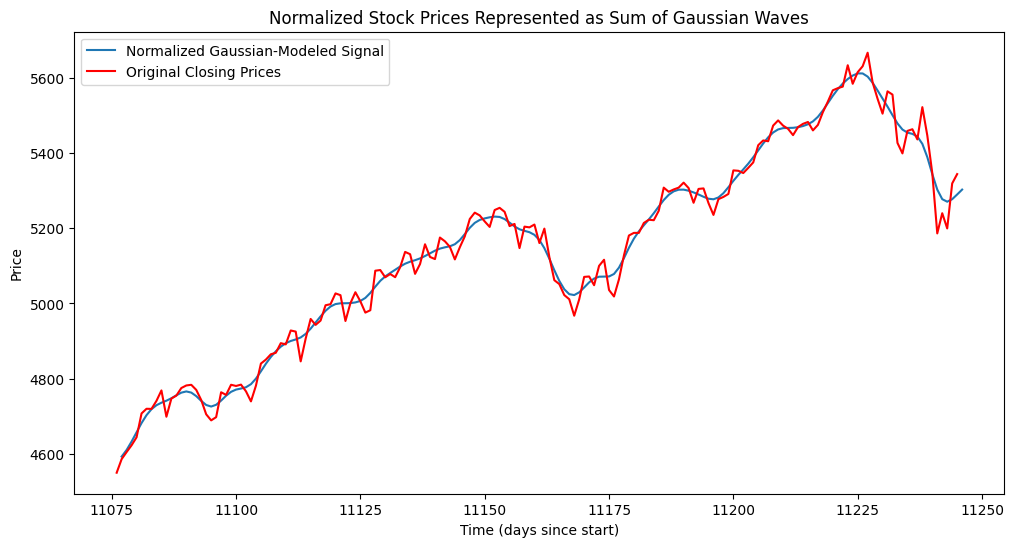

In [4]:
# Time axis for Gaussian pulses
t_continuous = np.linspace(1, len(df), num=len(df))
signal = np.zeros(t_continuous.shape)
gaussian_basis_sum = np.zeros_like(t_continuous)  # Sum of Gaussians

# Standard deviation for Gaussian pulses
sigma = 2
n = len(df)
t = np.arange(n)  # Creating t as a range based on the array length
gaussian_matrix = np.zeros((n, len(t_continuous)))

# Sum of Gaussian pulses
for i in range(n):
    A = df[i]  # Stock price as amplitude
    t0 = float(t[i])  # Ensure t0 is a scalar by casting to float
    
    # Gaussian pulse with amplitude A
    gaussian_pulse = A * np.exp(-((t_continuous - t0) ** 2) / (2 * sigma ** 2))
    signal += gaussian_pulse
    gaussian_matrix[i, :] = gaussian_pulse

    # Gaussian basis with amplitude 1
    gaussian_basis = np.exp(-((t_continuous - t0) ** 2) / (2 * sigma ** 2))
    gaussian_basis_sum += gaussian_basis

# Avoid dividing by zero by replacing zeros with small values in gaussian_basis_sum
gaussian_basis_sum[gaussian_basis_sum == 0] = 1e-8
normalized_signal = signal / gaussian_basis_sum

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(t_continuous[-170:], normalized_signal[-170:], label='Normalized Gaussian-Modeled Signal')
plt.plot(t[-170:], df[-170:], color='red', label='Original Closing Prices')
plt.title('Normalized Stock Prices Represented as Sum of Gaussian Waves')
plt.xlabel('Time (days since start)')
plt.ylabel('Price')
plt.legend()
plt.show()

**Caution: Making sigma higher then 2 causes highly volatile predictions near the end of the stock

## Learning Algorithm

In [5]:
bins = bin_data(normalized_signal)
X_train, y_train, X_test, y_test, train_index, test_index, train_size, test_size = split_data(bins, df, index, bin_size)

In [6]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [7]:
# now we make some predictions
y_pred = np.floor(model.predict(X_test))
y_test = np.floor(y_test)
print(y_pred.shape, y_test.shape)

for i in range(math.floor(len(y_pred) * 0.01)):
    print("prediction:", y_pred[i], "| actual:", y_test[i], "| difference:", abs(y_pred[i] - y_test[i]))
# print(y_pred)
print(X_test.shape)

(2176,) (2176,)
prediction: 2051.0 | actual: 2043.0 | difference: 8.0
prediction: 2071.0 | actual: 2073.0 | difference: 2.0
prediction: 2040.0 | actual: 2041.0 | difference: 1.0
prediction: 2008.0 | actual: 2005.0 | difference: 3.0
prediction: 2016.0 | actual: 2021.0 | difference: 5.0
prediction: 2044.0 | actual: 2038.0 | difference: 6.0
prediction: 2056.0 | actual: 2064.0 | difference: 8.0
prediction: 2060.0 | actual: 2060.0 | difference: 0.0
prediction: 2059.0 | actual: 2056.0 | difference: 3.0
prediction: 2071.0 | actual: 2078.0 | difference: 7.0
prediction: 2067.0 | actual: 2063.0 | difference: 4.0
prediction: 2035.0 | actual: 2043.0 | difference: 8.0
prediction: 2020.0 | actual: 2012.0 | difference: 8.0
prediction: 2013.0 | actual: 2016.0 | difference: 3.0
prediction: 1990.0 | actual: 1990.0 | difference: 0.0
prediction: 1939.0 | actual: 1943.0 | difference: 4.0
prediction: 1922.0 | actual: 1922.0 | difference: 0.0
prediction: 1927.0 | actual: 1923.0 | difference: 4.0
prediction: 

(8704,) (2176,)


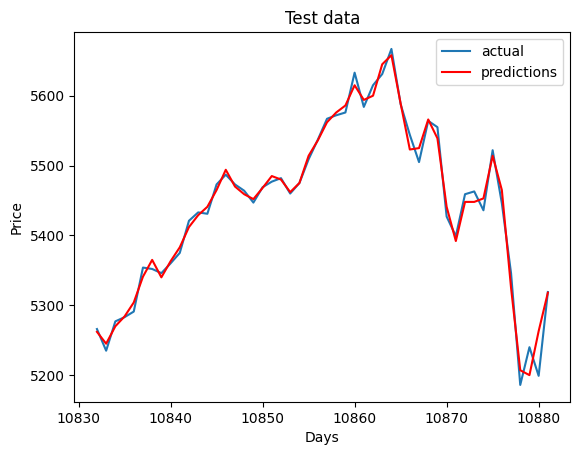

Correctly Classified: 1948/2176
Accuracy: 89.5220588235294%, error_margin of $20
Correctly Classified: 2149/2176
Accuracy: 98.7591911764706%, error_margin of $50
Correctly Classified: 2173/2176
Accuracy: 99.86213235294117%, error_margin of $100


In [8]:
print(train_index.shape, test_index.shape)
plt.plot(test_index[-50:], y_test[-50:], label="actual")
plt.plot(test_index[-50:], y_pred[-50:], color="red", label="predictions")
plt.title("Test data")
plt.ylabel("Price")
plt.xlabel("Days")
plt.legend()
plt.show()

error_margin = 20
results = abs(y_pred - y_test) <= error_margin
print(f"Correctly Classified: {np.sum(results)}/{len(results)}")
print(f"Accuracy: {100 * np.sum(results) / len(results)}%, error_margin of ${error_margin}")

error_margin = 50
results = abs(y_pred - y_test) <= error_margin
print(f"Correctly Classified: {np.sum(results)}/{len(results)}")
print(f"Accuracy: {100 * np.sum(results) / len(results)}%, error_margin of ${error_margin}")

error_margin = 100
results = abs(y_pred - y_test) <= error_margin
print(f"Correctly Classified: {np.sum(results)}/{len(results)}")
print(f"Accuracy: {100 * np.sum(results) / len(results)}%, error_margin of ${error_margin}")

In [9]:
print(f"Tomorrows Price: {y_pred[-1]}")
print(y_pred[-15:])
print(y_test[-15:])

Tomorrows Price: 5318.0
[5525. 5566. 5539. 5441. 5392. 5448. 5448. 5453. 5514. 5465. 5325. 5207.
 5200. 5263. 5318.]
[5505. 5564. 5555. 5427. 5399. 5459. 5463. 5436. 5522. 5446. 5346. 5186.
 5240. 5199. 5319.]


[*********************100%***********************]  1 of 1 completed


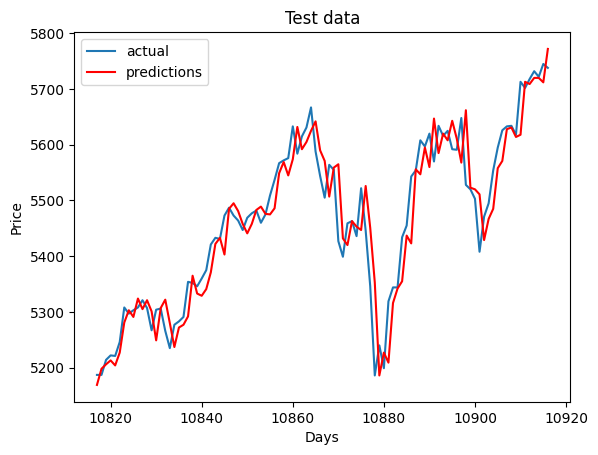

[*********************100%***********************]  1 of 1 completed


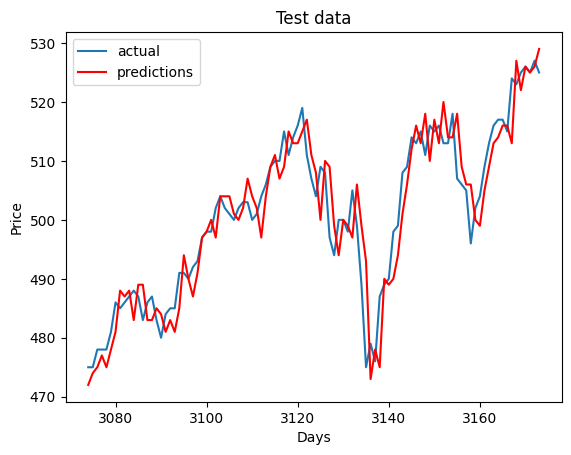

[*********************100%***********************]  1 of 1 completed


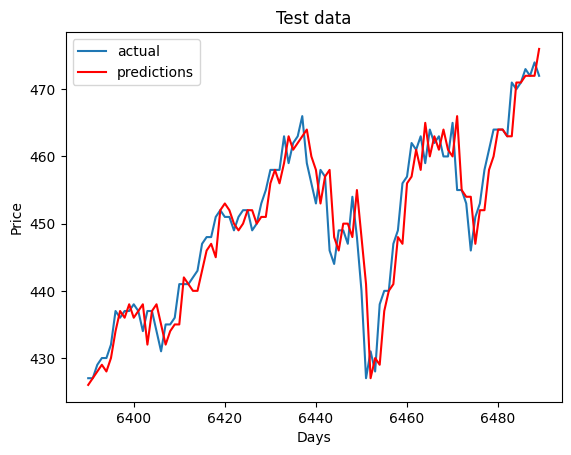

[*********************100%***********************]  1 of 1 completed


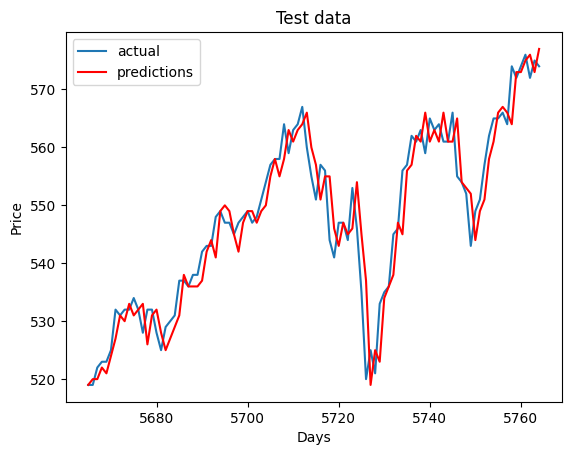

[*********************100%***********************]  1 of 1 completed


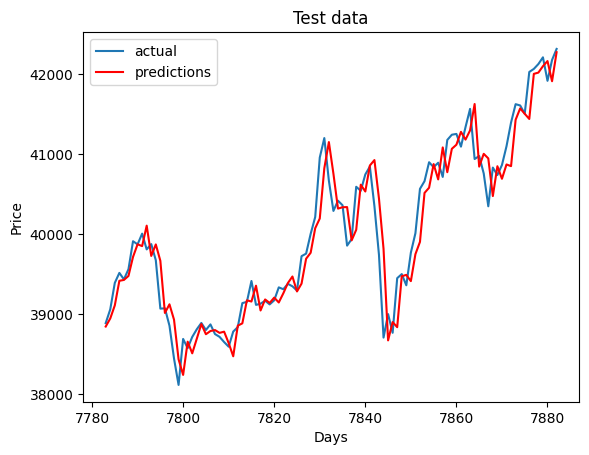

[*********************100%***********************]  1 of 1 completed


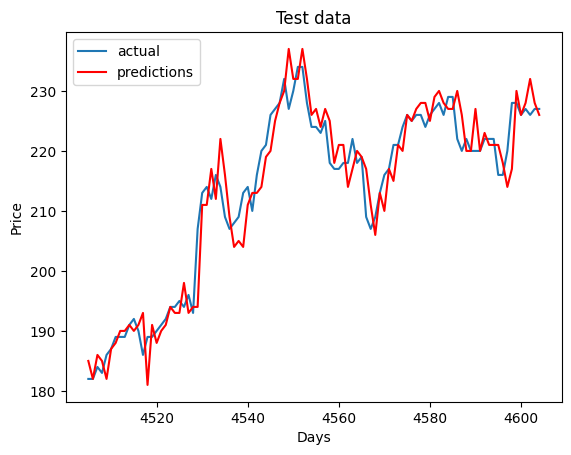

In [10]:
stock = [['^GSPC', '1980-01-01', '2024-10-01'],
        ['VOO', '1980-01-01', '2024-10-01'],
        ['VIIIX', '1980-01-01', '2024-10-01'],
        ['IVV', '1980-01-01', '2024-10-01'],
        ['^DJI', '1980-01-01', '2024-10-01'],
        ['AAPL', '2005-01-01', '2024-10-01']]
for i in stock:
    test_stock(i)